Note this must be run in env mypython3 in Python3 (i.e. activate environment as below before running)

conda activate mypython3


Hypothesis:

An acceleration of the water cycle under climate climate change means 'the wet areas get wetter, the dry get dryer' (Held and Soden, 2006 https://doi.org/10.1175/JCLI3990.1
). This will shift CO2 uptake capacity from the high to low-latitudes through alkalinity concentration/dilution. The wet areas (high latitudes) tend to be where anthropogenic carbon is taken into the interior ocean, so a shift in uptake towards the dry areas (STGs etc), will result in this carbon increasingly mainly sitting in the mixed layer rather than being taken into the interior (in a relative sense), compromising the long-term ocean C. sink.

There is an argument that climate models underestimate the intensification of the water cycle (they underestimate observed change Durack et al., 2012, DOI: 10.1126/science.1212222), I need to understand the debate about this (e.g. Helm et al., 2010, https://doi.org/10.1029/2010GL044222) better, if true, this means models may may be biased high in terms of ocean carbon storage.

I start by looking at this in a back of the envelope way, then using UKESM preindustrial climatology look at this spatially.


In [8]:
%load_ext autoreload
%autoreload 2

import iris
import numpy as np
from matplotlib import pyplot as plt
import iris.quickplot as qplt
from PyCO2SYS import CO2SYS
import PyCO2SYS as pyco2
#https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/
# from PyCO2SYS.api import CO2SYS_wrap as co2sys
import iris.coord_categorisation
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import iris.plot as iplt
from tqdm import tqdm
import math

Pa_to_uatm = ((1.0/0.9869e-1))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def extract_and_avg_yr_range(cube,start_year,end_year):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.squeeze(np.where((cube.coord('year').points >= start_year) & (cube.coord('year').points <= end_year)))
    return cube[loc].collapsed('time',iris.analysis.MEAN)

def extract_range(cube,start_year,end_year):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.squeeze(np.where((cube.coord('year').points >= start_year) & (cube.coord('year').points <= end_year)))
    return cube[loc]

def prepare_cmip_for_co2sys(cube):
    cube_data = cube.data.data
    cube_data[np.where(cube.data.mask)] = np.nan
    return cube_data


def area_avg(cube):
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)


def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    return cube_region_tmp.intersection(latitude=(lat_south,lat_north))


def add_year_coord(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube

def sort_years(cube):
    my_sort = np.argsort(cube.coord('year').points)
    return cube[my_sort,:,:]


def monthly_to_annual(in_cube):
    iris.coord_categorisation.add_year(in_cube, 'time',name='year')
    return in_cube.aggregated_by(['year'],iris.analysis.MEAN)

## Back of the envelope examination

Broadly considering the 21st centry response to a business as usual climate change scenario.


Assumptions:
- evaporation increases alkalinity and salinity linearly over 100 years by 1% (This number comes from the fact that there has been ~0.1pss change observed over the last 3o years, e.g. Helm et al., 2010, https://doi.org/10.1029/2010GL044222)
- temperature rises by 4 degrees iover 100 years
- pCO2 rises by 1% a year from ~400 to ~1000 uatm.

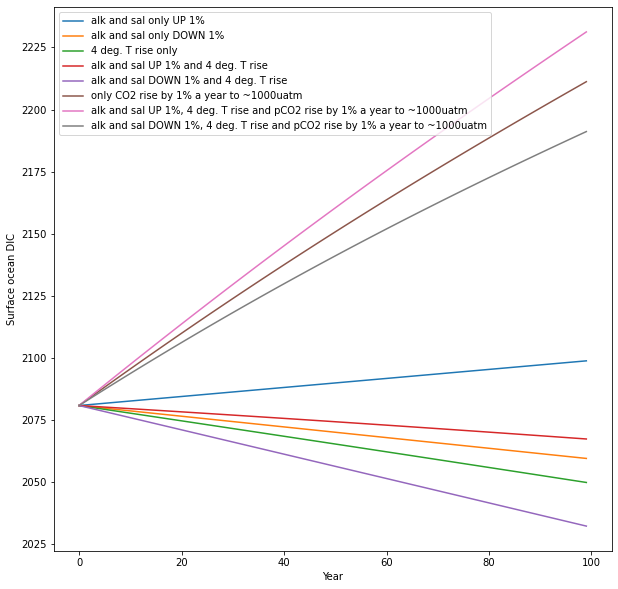

In [17]:
percent_increase = 1.0

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
alk_init = 2300.0
par1 = np.linspace(alk_init,alk_init+alk_init*(percent_increase/100),100)  # value of the first parameter
par1b = np.linspace(alk_init,alk_init-alk_init*(percent_increase/100),100)  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = 400.0
# * Pa_to_uatm
par2b = np.array([400 * (math.pow((1 + 0.01), x)) for x in range(100)])
# * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal_init = 35.0
sal = np.linspace(sal_init,sal_init+sal_init*(percent_increase/100),100)  # value of the first parameter # Salinity of the sample
salb = np.linspace(sal_init,sal_init-sal_init*(percent_increase/100),100)  # value of the first parameter # Salinity of the sample
temp_init =15.0
tempin = temp_init  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict1 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

tempin2 = np.linspace(temp_init,temp_init+4.0,100)
CO2dict2 = CO2SYS(np.linspace(alk_init,alk_init,100),par2,par1type,par2type,np.linspace(sal_init,sal_init,100),tempin2,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

CO2dict3 = CO2SYS(par1,par2,par1type,par2type,sal,tempin2,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

CO2dict4 = CO2SYS(par1b,par2,par1type,par2type,salb,tempin2,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

CO2dict5 = CO2SYS(np.linspace(alk_init,alk_init,100),par2b,par1type,par2type,np.linspace(sal_init,sal_init,100),tempin2,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

CO2dict6 = CO2SYS(par1,par2b,par1type,par2type,sal,tempin2,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

CO2dict7 = CO2SYS(par1b,par2b,par1type,par2type,salb,tempin2,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

CO2dict8 = CO2SYS(par1b,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

plt.figure(figsize=(10,10))

plt.plot(CO2dict1['TCO2'],label='alk and sal only UP 1%')
plt.plot(CO2dict8['TCO2'],label='alk and sal only DOWN 1%')
plt.plot(CO2dict2['TCO2'],label='4 deg. T rise only')
plt.plot(CO2dict3['TCO2'],label='alk and sal UP 1% and 4 deg. T rise')
plt.plot(CO2dict4['TCO2'],label='alk and sal DOWN 1% and 4 deg. T rise')
plt.plot(CO2dict5['TCO2'],label='only CO2 rise by 1% a year to ~1000uatm')
plt.plot(CO2dict6['TCO2'],label='alk and sal UP 1%, 4 deg. T rise and pCO2 rise by 1% a year to ~1000uatm')
plt.plot(CO2dict7['TCO2'],label='alk and sal DOWN 1%, 4 deg. T rise and pCO2 rise by 1% a year to ~1000uatm')



plt.ylabel('Surface ocean DIC')
plt.xlabel('Year')

plt.legend()

So, it looks like:
- In areas which will get wetter, the dilution effect is about as big as the temperature effect.
- The effect is approximately symetrical (i.e. a 1% dilution has approx the equal effect as a 1% concentration but of oposite sign).
- The effect is substantial compared to the general response to rising CO2.

## Idealised concentration/dilution of alkalinity and salinity from UKESM preindustrial climatology

Here I take a preindustrial climatology (just because I had the data available) of T, S, pCO2 and TALK and look at how the equilibrium DIC changes when TALK and S and diluted or concentrated based on the spatial pattern defined by the 'wet gets wetter, dry gets dryer' hypothesis. i.e. I take the precipitation minus evaporation field, calculate where this is greater or less than 0 (to define a mask of the wet areas and dry areas), then increase TALK and S values  by 1% in the dry areas and decrease TALK and S by 1% in the wet areas. I compare the DIC in equilibrium with these adjusted fields with those with the unadjusted TALK and S fields.

- On mac files in Downloads are time averaged surface fields from 196001-204912 from the PI control run, found here on server: $groupserv:/data/BatCaveNAS/ph290/cmip6/picontrol

files:

dissic_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

evspsbl_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

pr_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

sos_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

talk_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

tos_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

spco2_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_remap_tavg.nc

In [65]:
# Read in the data

directory = '/Users/ph290/Downloads/'

model = 'UKESM1-0-LL'

file1 = directory+'tos_Omon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'
file2 = directory+'sos_Omon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'
file3 = directory+'dissic_Omon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'
file4 = directory+'talk_Omon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'
file5 = directory+'spco2_Omon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'
file6 = directory+'pr_Amon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'
file7 = directory+'evspsbl_Amon_'+model+'_piControl_r1i1p1f2_gn_remap_tavg.nc'

c_tos = iris.load_cube(file1)[0]
c_sos = iris.load_cube(file2)[0]
c_dissic = iris.load_cube(file3)[0][0]
c_talk = iris.load_cube(file4)[0][0]
c_spco2 = iris.load_cube(file5)[0]
c_pr = iris.load_cube(file6)[0]
c_evspsbl = iris.load_cube(file7)[0]
p_minus_e = c_pr - c_evspsbl

c_tos_data = c_tos.data.data
c_sos_data = c_sos.data.data
c_dissic_data = c_dissic.data.data
c_talk_data = c_talk.data.data
c_spco2_data = c_spco2.data.data

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'sos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'dissic'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'dissic'
  warnings.warn(message % (variable_name, nc_var_name))
/Us

### 'Baseline' DIC field in equilibrium with model alkalinity, T, S and pCO2

In [75]:

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data# Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

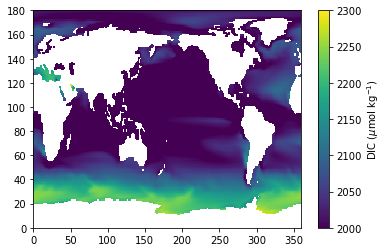

In [93]:
plt.pcolormesh(np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=2000,vmax=2300)
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')

### Using model precip minus evap field to create mask for areas to get wetter and areas to get drier

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/coords.py:1192: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn('Coordinate {!r} is not bounded, guessing '
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/coords.py:1192: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn('Coordinate {!r} is not bounded, guessing '


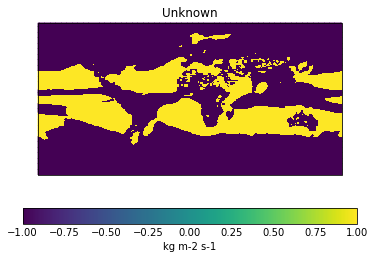

In [94]:
p_minus_e_pos_neg = p_minus_e.copy()
p_minus_e_pos_neg_data = p_minus_e_pos_neg.data
p_minus_e_pos_neg_data2 = p_minus_e_pos_neg_data.copy()
p_minus_e_pos_neg_data2[np.where(p_minus_e_pos_neg_data <= 0.0)] = 1.0
p_minus_e_pos_neg_data2[np.where(p_minus_e_pos_neg_data > 0.0)] = -1.0
p_minus_e_pos_neg.data = p_minus_e_pos_neg_data2
qplt.pcolormesh(p_minus_e_pos_neg)

### DIC field in equilibrium with model T and pCO2 but with alkalinity and S increasing by 1% in 'dry' areas and decreasing by 1% in 'wet' areas
i.e. where P minus E > 1 alkalinity and salinity reduced by 1%, where P minus E < 1 alkalinity and salinity increased by 1%

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/equilibria/p1atm.py:74: RuntimeWarning: invalid value encountered in sqrt
  lnKF = 1590.2 / TempK - 12.641 + 1.525 * IonS ** 0.5
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/equilibria/p1atm.py:101: RuntimeWarning: overflow encountered in power
  return 10.0 ** logKB
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/equilibria/p1atm.py:406: RuntimeWarning: overflow encountered in power
  K2 = 10.0 ** -pK2  # this is on the NBS scale
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/equilibria/p1atm

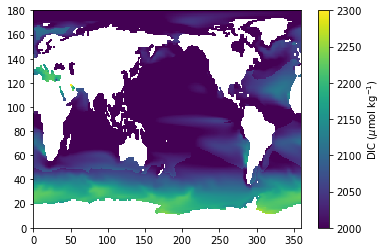

In [95]:

# c_talk.data.data + (0.1.0 * p_minus_e_pos_neg.data.data * c_talk.data.data)

# positive e-p area get 1% more positive, nevative get 1% more negative
c_sos_data2 = c_sos.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_sos.data.data)
c_talk_data2 = c_talk.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_talk.data.data)


par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data2 * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data2 # Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

CO2dict2 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)
plt.pcolormesh(np.reshape(CO2dict2['TCO2'],np.shape(c_talk_data)),vmin=2000,vmax=2300)
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')

### Standard preindustrial conditions minus preindustrial conditions with alkalinity and salinity concentrated/diluted by evap./precip. change

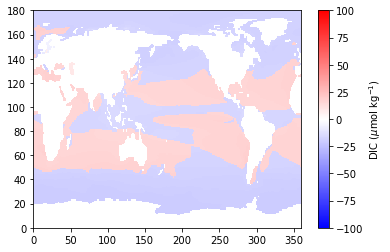

In [96]:
plt.pcolormesh(np.reshape(CO2dict2['TCO2'],np.shape(c_talk_data)) - np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=-100,vmax=100,cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')


### as above but with temperature also increasing by 4 degrees

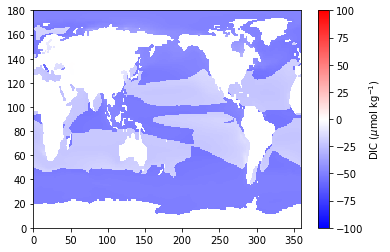

In [102]:
# positive e-p area get 1% more positive, nevative get 1% more negative
c_sos_data2 = c_sos.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_sos.data.data)
c_talk_data2 = c_talk.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_talk.data.data)


par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data2 * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data2 # Salinity of the sample
tempin = c_tos_data + 4.0  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

CO2dict3 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)


plt.pcolormesh(np.reshape(CO2dict3['TCO2'],np.shape(c_talk_data)) - np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=-100,vmax=100,cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')



### for context, the change occuring just in response to 4 degrees of warming 

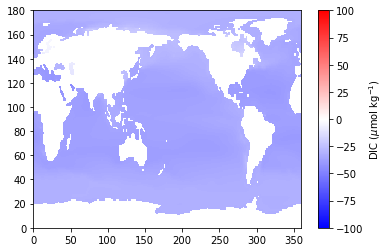

In [104]:

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data# Salinity of the sample
tempin = c_tos_data + 4.0  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict4 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)


plt.pcolormesh(np.reshape(CO2dict4['TCO2'],np.shape(c_talk_data)) - np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=-100,vmax=100,cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')



### Now considering in pCO2 increase by 600uatm without TALK, S or temperature change

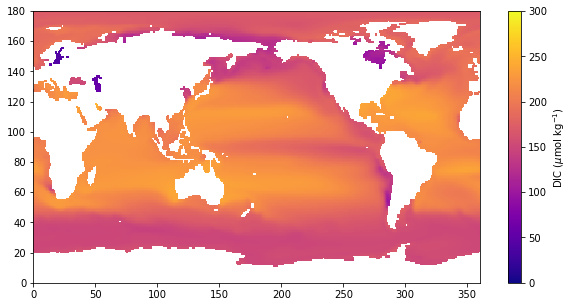

In [117]:
# positive e-p area get 1% more positive, nevative get 1% more negative
c_sos_data2 = c_sos.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_sos.data.data)
c_talk_data2 = c_talk.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_talk.data.data)


par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = (c_spco2_data * Pa_to_uatm) + 600.0
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data # Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

CO2dict5 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

plt.figure(figsize=(10,5))
plt.pcolormesh(np.reshape(CO2dict5['TCO2'],np.shape(c_talk_data)) - np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=0,vmax=300,cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')



### Now adding in pCO2 increase (increasing by 600uatm), so considering 1% S and TALK change, pCO2 increasing by 600uatm but NO temp. increase

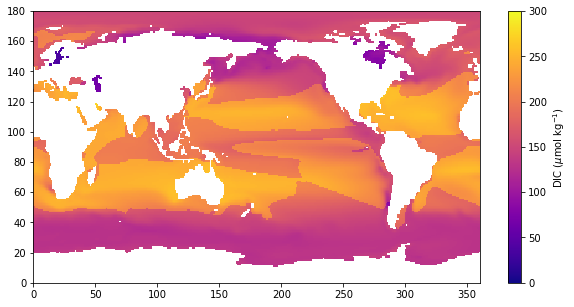

In [118]:
# positive e-p area get 1% more positive, nevative get 1% more negative
c_sos_data2 = c_sos.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_sos.data.data)
c_talk_data2 = c_talk.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_talk.data.data)


par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data2 * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = (c_spco2_data * Pa_to_uatm) + 600.0
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data2 # Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

CO2dict5 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

plt.figure(figsize=(10,5))
plt.pcolormesh(np.reshape(CO2dict5['TCO2'],np.shape(c_talk_data)) - np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=0,vmax=300,cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')



### Finally the change in response to 1% S and TALK change, 4 degrees of warming and pCO2 increasing by 600uatm

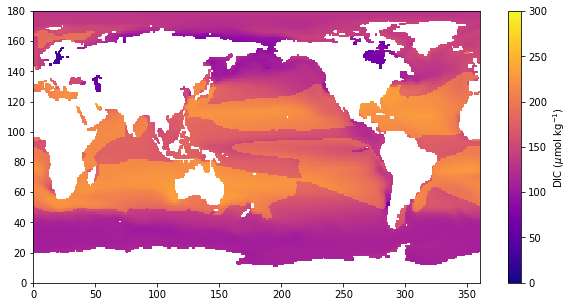

In [119]:
# positive e-p area get 1% more positive, nevative get 1% more negative
c_sos_data2 = c_sos.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_sos.data.data)
c_talk_data2 = c_talk.data.data + (0.01 * p_minus_e_pos_neg.data.data * c_talk.data.data)


par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data2 * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = (c_spco2_data * Pa_to_uatm) + 600.0
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data2 # Salinity of the sample
tempin = c_tos_data + 4.0  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

CO2dict6 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

plt.figure(figsize=(10,5))

plt.pcolormesh(np.reshape(CO2dict6['TCO2'],np.shape(c_talk_data)) - np.reshape(CO2dict['TCO2'],np.shape(c_talk_data)),vmin=0,vmax=300,cmap='plasma')
cbar = plt.colorbar()
cbar.set_label('DIC ($\mu$mol kg$^{-1}$)')



## Conclusions:

- The concentration/dilution effect has teh potential to be big (reginally, of similar magnitude to the temperature driven change in the sink strength)
- The effect really seems to have the potential to comprimise the important global CO2 sinks

## CMIP6 SSP5-8.5 analysis 

660x180 regridded files in Downloads, copied from $groupserv:/data/BatCaveNAS/ph290/cmip6/regridded/UKESM1-0-LL* .

UKESM1-0-LL_dissic_ssp585_r1i1p1f2_gn_regridded.nc

UKESM1-0-LL_siconc_ssp585_r1i1p1f2_gn_regridded.nc    

UKESM1-0-LL_sos_ssp585_r1i1p1f2_gn_regridded.nc

UKESM1-0-LL_spco2_ssp585_r1i1p1f2_gn_regridded.nc

UKESM1-0-LL_talk_ssp585_r1i1p1f2_gn_regridded.nc

UKESM1-0-LL_tos_ssp585_r1i1p1f2_gn_regridded.nc

In [99]:
directory = '/Users/ph290/Downloads/'

model = 'UKESM1-0-LL'

file1 = directory+model+'_tos_ssp585_r1i1p1f2_gn_regridded.nc'
file2 = directory+model+'_sos_ssp585_r1i1p1f2_gn_regridded.nc'
file3 = directory+model+'_dissic_ssp585_r1i1p1f2_gn_regridded.nc'
file4 = directory+model+'_talk_ssp585_r1i1p1f2_gn_regridded.nc'
file5 = directory+model+'_spco2_ssp585_r1i1p1f2_gn_regridded.nc'

file6 = directory+model+'_tas_ssp585_r1i1p1f2_gn_regridded.nc'
file7 = directory+model+'_psl_ssp585_r1i1p1f2_gn_regridded.nc'
file8 = directory+'co2mass_Amon_'+model+'_ssp585_r1i1p1f2_gm.nc'



c_tos = monthly_to_annual(iris.load_cube(file1))
c_sos = monthly_to_annual(iris.load_cube(file2))
c_dissic = monthly_to_annual(iris.load_cube(file3))
c_dissic = c_dissic.collapsed('depth',iris.analysis.MEAN)
c_talk = monthly_to_annual(iris.load_cube(file4))
c_talk = c_talk.collapsed('depth',iris.analysis.MEAN)
c_spco2 = monthly_to_annual(iris.load_cube(file5))

c_tas = monthly_to_annual(iris.load_cube(file6))
c_psl = monthly_to_annual(iris.load_cube(file7))
c_co2mass = monthly_to_annual(iris.load_cube(file8))


c_tos_data = c_tos.data.data
c_sos_data = c_sos.data.data
c_dissic_data = c_dissic.data.data
c_talk_data = c_talk.data.data
c_spco2_data = c_spco2.data.data

c_tas_data = c_tas.data.data
c_psl_data = c_psl.data.data
c_co2mass_data_timeseries = c_co2mass.data.data

c_co2mass_data_tmp = np.tile(c_co2mass_data_timeseries, (np.shape(c_tas_data)[1],np.shape(c_tas_data)[2],1))
c_co2mass_data = np.moveaxis(c_co2mass_data_tmp,2,0)

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'tos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'sos'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'dissic'
  warnings.warn(message % (variable_name, nc_var_name))
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'dissic'
  warnings.warn(message % (variable_name, nc_var_name))
/Us

In [12]:
# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data# Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/buffers/__init__.py:67: RuntimeWarning: divide by zero encountered in true_divide
  return dTA_dPH__FC / dTC_dPH__FC


In [13]:
c_dissic_data_out = np.reshape(CO2dict['TCO2'],np.shape(c_talk_data))
c_dissic_out = c_dissic.copy()
c_dissic_out.data = c_dissic_data_out


/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/coords.py:1192: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn('Coordinate {!r} is not bounded, guessing '
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/iris/coords.py:1192: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn('Coordinate {!r} is not bounded, guessing '


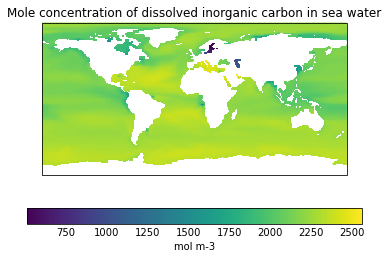

In [14]:
qplt.pcolormesh(c_dissic_out[-1])

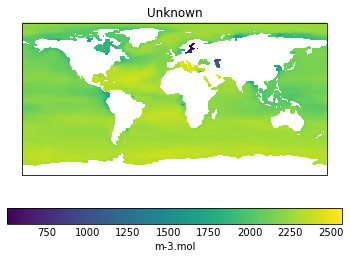

In [15]:
qplt.pcolormesh(c_dissic[-1] * 1000.0)

## Keeping pCO2 and T at level of climatology from 1st 20 years

In [30]:
c_spco2_data_init_climatology_repeat = np.tile(np.mean(c_spco2_data[0:20,:,:],axis=0), (np.shape(c_spco2_data)[0],1,1))
c_tos_data_init_climatology_repeat = np.tile(np.mean(c_tos_data[0:20,:,:],axis=0), (np.shape(c_tos_data)[0],1,1))

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 4  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_spco2_data_init_climatology_repeat * Pa_to_uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data # Salinity of the sample
tempin = c_tos_data_init_climatology_repeat  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict2 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.
Some input pH values are impossibly high given the input alkalinity;
returning np.nan rather than negative DIC values.


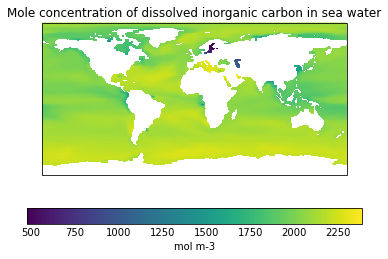

In [32]:
c_dissic_data_out2 = np.reshape(CO2dict2['TCO2'],np.shape(c_talk_data))
c_dissic_out2 = c_dissic.copy()
c_dissic_out2.data = c_dissic_data_out2
qplt.pcolormesh(c_dissic_out2[-1])

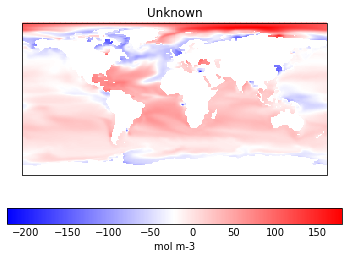

In [33]:
qplt.pcolormesh(c_dissic_out2[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out2[0:20].collapsed('time',iris.analysis.MEAN),cmap='bwr')

note [DOUBLE NOTE - results below disprove this] - big increase in arctic is presumably because the CO2 can get in - this is 'cos I'm using pCO2 in seawater whereas I would probably be better off using a gaseous CO2 to find out what would be in equilibrium with that water

## Below, I'm doing this based on fCO2 calculated from atmospheric CO2

In [72]:

def total_atm_co2_mass_to_ppmv(total_atm_co2_mass):
    # mole fraction is expressed as parts per million (ppm).
    # For example, CO2 concentration of 365 ppmv is 365x10-6 mol/mol i.e. a mole fraction of 365x10-6
    mass_of_atmopshere = 5.1480e18
    molar_mass_co2 = 44.0095
    avg_molar_mass_dry_air = 28.97
    atm_co2_ppmv = ((total_atm_co2_mass/mass_of_atmopshere)/(molar_mass_co2/avg_molar_mass_dry_air))*1.0e6
    return atm_co2_ppmv

# atm_co2_ppmv = total_atm_co2_mass_to_ppmv(total_atm_co2_mass)

# Fugacity of CO2 in air
# https://cdiac.ess-dive.lbl.gov/ftp/cdiac74/sop24.pdf

# T = 298.15 #K
# p = 101325.0 # Pa (1 atm) ;
# xCO2 = 350.0 #atmospheric ppmv 

def fugacity_of_CO2_in_air(T,p,xCO2):
    # output in uatm
    # https://cdiac.ess-dive.lbl.gov/ftp/cdiac74/sop24.pdf
    # T = e.g. 298.15 #K
    # p = e.g. 101325.0 # Pa (1 atm) ;
    # xCO2 = e.g. 350.0 #atmospheric CO2 dry air mole fraction
    BT = -1636.75 + 12.0408 * (T) - 3.27957e-2 * np.power(T,2) + 3.16528e-5* np.power(T,3) #cm3·mol–1 virial coefficient for the pure CO2
    delta_CO2air = 57.7 - 0.118 * (T)  # (where 273 < (T/K) < 313) Virial coefficient of carbon dioxide in air, cm3·mol–1
    R = 8.31451 # gas constant m3⋅Pa⋅K−1⋅mol−1
    fCO2 = (xCO2 * 1.0e-6) * p * np.exp((((BT * 1.0e-6) + (2 * np.power((1 - (xCO2 * 1.0e-6)),2)) * (delta_CO2air * 1.0e-6)) * p ) / (R * T))
    return fCO2/(101325.0e-6) # convert from Pa to uatm.

# fCO2 = fugacity_of_CO2_in_air(T,p,xCO2)

In [139]:


xCO2 = total_atm_co2_mass_to_ppmv(c_co2mass_data)
fCO2 = fugacity_of_CO2_in_air(c_tas_data,c_psl_data,xCO2)

In [141]:
# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
par2 = fCO2 # uatm
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data# Salinity of the sample
tempin = c_tos_data  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:15: RuntimeWarning: divide by zero encountered in true_divide
  c2 = KB - (TB * KB + K1 * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:16: RuntimeWarning: divide by zero encountered in true_divide
  c1 = -K1 * (2 * K2 * CO2 + KB * CO2) / CBAlk
/Users/ph290/miniconda2/envs/mypython3/lib/python3.8/site-packages/PyCO2SYS/solve/initialise.py:17: RuntimeWarning: divide by zero encountered in true_divide
  c0 = -2 * K1 * K2 * KB * CO2 / CBAlk


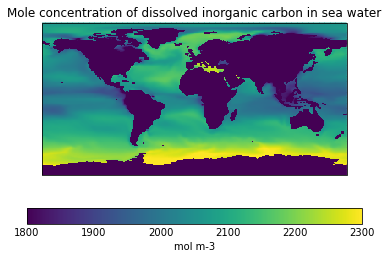

In [145]:
c_dissic_data_out = np.reshape(CO2dict['TCO2'],np.shape(c_talk_data))
c_dissic_out = c_dissic.copy()
c_dissic_out.data = c_dissic_data_out
qplt.pcolormesh(c_dissic_out[0],vmin=1800,vmax=2300)

In [146]:
c_fCO2_data_init_climatology_repeat = np.tile(np.mean(fCO2[0:20,:,:],axis=0), (np.shape(fCO2)[0],1,1))
c_tos_data_init_climatology_repeat = np.tile(np.mean(c_tos_data[0:20,:,:],axis=0), (np.shape(c_tos_data)[0],1,1))

# https://pyco2sys.readthedocs.io/en/latest/co2sys_nd/#arguments
par1type = 1  # The first parameter supplied is of type "1", which is "alkalinity"
par1 = c_talk_data * 1.0e3  # value of the first parameter
par2type = 5  # The first parameter supplied is of type "1", which is "DIC"
par2 = c_fCO2_data_init_climatology_repeat
# ^ value of the second parameter, which is a long vector of different DIC's!
sal = c_sos_data # Salinity of the sample
tempin = c_tos_data_init_climatology_repeat  # Temperature at input conditions
presin = 0  # Pressure    at input conditions
tempout = 0  # Temperature at output conditions - doesn't matter in this example
presout = 0  # Pressure    at output conditions - doesn't matter in this example
sil = 0  # Concentration of silicate  in the sample (in umol/kg)
po4 = 0  # Concentration of phosphate in the sample (in umol/kg)
pHscale = 1  # pH scale at which the input pH is reported ("1" means "Total Scale")  - doesn't matter in this example
k1k2c = 4  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("4" means "Mehrbach refit")
kso4c = 1  # Choice of HSO4- dissociation constants KSO4 ("1" means "Dickson")

# Do the calculation. See CO2SYS's help for syntax and output format
CO2dict2 = CO2SYS(par1,par2,par1type,par2type,sal,tempin,tempout,presin,presout,sil,po4,pHscale,k1k2c,kso4c)

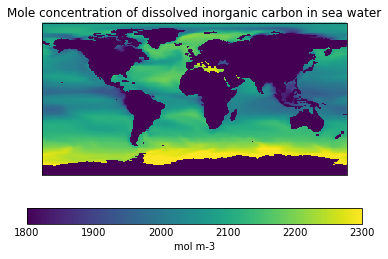

In [147]:
c_dissic_data_out2 = np.reshape(CO2dict2['TCO2'],np.shape(c_talk_data))
c_dissic_out2 = c_dissic.copy()
c_dissic_out2.data = c_dissic_data_out2
qplt.pcolormesh(c_dissic_out2[0],vmin=1800,vmax=2300)

## 21stC story

The 21stC DIC change under SSP5-8.5 has considerable spatial variability, with the areas of weakest DIC growth corresponding to important carbon sink regions.

The plot below shows the UKESMs 2080-2100 mean minus the 2015-2035 mean

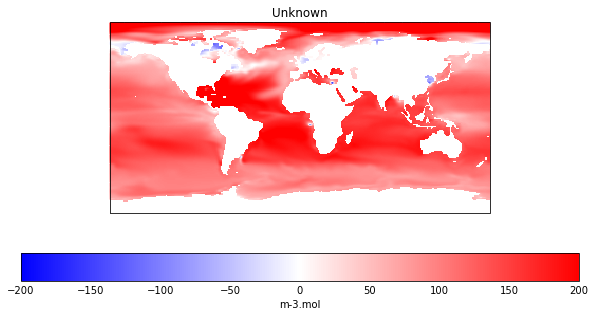

In [185]:
plt.figure(figsize=(10,5))
change_in_model_dissic = (c_dissic[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic[0:20].collapsed('time',iris.analysis.MEAN))*1000.0
qplt.pcolormesh(change_in_model_dissic,cmap='bwr',vmin=-200,vmax=200)

One could suggest that this is because DIC is removed form the surface in these regions BUT...

...we can replicate this pattern when calculating the DIC in equilibrium with the time-varying atm. CO2 when just temperature, salinity and alkalinity are changing.



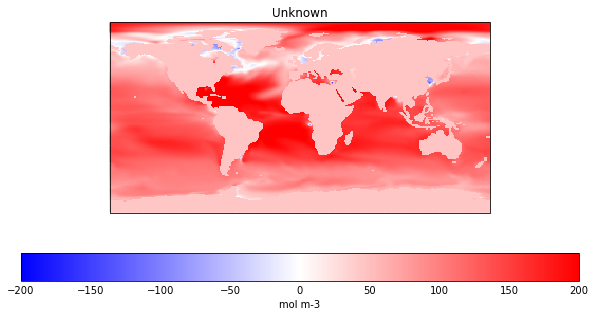

In [186]:
plt.figure(figsize=(10,5))
DIC_change_all_factors = c_dissic_out[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(DIC_change_all_factors,cmap='bwr',vmin=-200,vmax=200)

We can then ask what the DIC change would look like if only alkalinity and salinity were changing, and we see that this basically explains the spatial structure

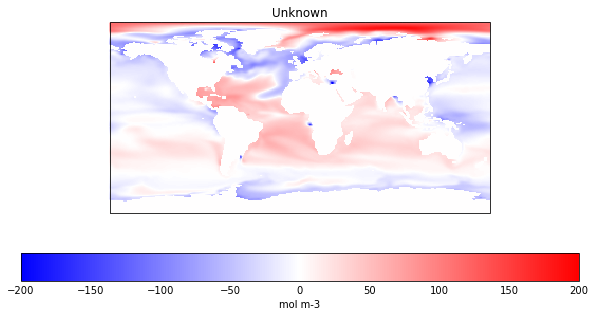

In [187]:
plt.figure(figsize=(10,5))
DIC_change_just_alk_and_sal_change = c_dissic_out2[-20::].collapsed('time',iris.analysis.MEAN) - c_dissic_out2[0:20].collapsed('time',iris.analysis.MEAN)
qplt.pcolormesh(DIC_change_just_alk_and_sal_change,cmap='bwr',vmin=-200,vmax=200)

Interestingly, if we take the alklainity driven change away from the all-factors change, alkalinity is essentially responsable for the high uptake in the Arctic, which is not what I would have epxected! Need to look into this, but perhaps just a model specific rebound from the sudden drop in uptake before/early-in the 21stC, which negates much DIC uptake at that time.

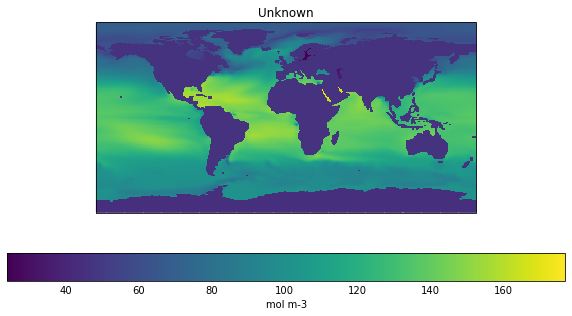

In [188]:
plt.figure(figsize=(10,5))
qplt.pcolormesh(DIC_change_all_factors - DIC_change_just_alk_and_sal_change)

An important conclusion from all of this is that the major sink regions (N. Atl. and S. Ocean) actually have pretty small DIC increases over the 21stC because of the (freshening?) driven alkalnity changes